# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [87]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [88]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [89]:
# Check the structure of the data after it's loaded 
azdias.shape

(891221, 85)

In [90]:
feat_info.shape

(85, 4)

In [91]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [92]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


## Step 1: Preprocessing

### Assess Missing Data

Which columns actually have missing values and how many of them are missing?

In [93]:
col_w_nan = azdias.isna().sum()
col_w_nan = col_w_nan[col_w_nan != 0]
col_w_nan.sort_values(ascending=False)

KK_KUNDENTYP           584612
KBA05_ANTG3            133324
KBA05_ANTG2            133324
KBA05_ANTG4            133324
KBA05_BAUMAX           133324
KBA05_GBZ              133324
KBA05_ANTG1            133324
MOBI_REGIO             133324
KKK                    121196
REGIOTYP               121196
PLZ8_ANTG1             116515
PLZ8_ANTG2             116515
PLZ8_ANTG3             116515
PLZ8_ANTG4             116515
PLZ8_BAUMAX            116515
PLZ8_HHZ               116515
PLZ8_GBZ               116515
W_KEIT_KIND_HH         107602
KBA13_ANZAHL_PKW       105800
CAMEO_DEUG_2015         98979
CAMEO_INTL_2015         98979
CAMEO_DEU_2015          98979
ORTSGR_KLS9             97216
RELAT_AB                97216
ARBEIT                  97216
ANZ_HH_TITEL            97008
EWDICHTE                93740
BALLRAUM                93740
INNENSTADT              93740
GEBAEUDETYP_RASTER      93155
WOHNLAGE                93148
OST_WEST_KZ             93148
MIN_GEBAEUDEJAHR        93148
GEBAEUDETY

In [94]:
print("{} out of {} colulumns in azdias have missing values".format(len(col_w_nan), azdias.shape[1]))

53 out of 85 colulumns in azdias have missing values


### Converting Missing Value Codes to NaNs

The fourth value of the feat_info dataframe has missing value codes. The codes indicate missing or unknown data.

In [95]:
feat_info.missing_or_unknown.unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [96]:
#Convert these strings to list of int & string
def convert(i) :
    """
    inputs :
    i - string
    output :
    either the integer version or i itself
    -helper function
    """
    if (i != 'X' and i != 'XX' and len(i) > 0) :
        return int(i)
    return i

def create_list(s) :
    """
    inputs :
    s - string
    output :
    a list contatining either the integer components 
    or 'X' and 'XX' 
    """
    s = s[1:-1]
    s = s.split(',')
    return [convert(i) for i in s]

feat_info.missing_or_unknown = feat_info.missing_or_unknown.apply(create_list)
feat_info.missing_or_unknown

0        [-1, 0]
1     [-1, 0, 9]
2        [-1, 0]
3            [0]
4           [-1]
         ...    
80          [-1]
81          [-1]
82       [-1, 9]
83       [-1, 0]
84       [-1, 9]
Name: missing_or_unknown, Length: 85, dtype: object

In [97]:
#Map the column names to missing data encoding
missing_data_dict = dict(zip(feat_info.attribute, feat_info.missing_or_unknown))

In [98]:
#TEST IT
feat_info.attribute[2], feat_info.missing_or_unknown[2]

('ANREDE_KZ', [-1, 0])

In [99]:
missing_data_dict['ANREDE_KZ']

[-1, 0]

In [100]:
# Identify missing or unknown data values and convert them to NaNs.
df = azdias.copy()
for col in missing_data_dict.keys(): 
    nan_before = df[col].isnull().sum()
    df.loc[df[col].isin(missing_data_dict[col]), col] = np.nan
    nan_after = df[col].isnull().sum()
    diff = nan_after - nan_before
    print('{} gained {} more missing values'.format(col, diff), '\n')

AGER_TYP gained 685843 more missing values 

ALTERSKATEGORIE_GROB gained 2881 more missing values 

ANREDE_KZ gained 0 more missing values 

CJT_GESAMTTYP gained 0 more missing values 

FINANZ_MINIMALIST gained 0 more missing values 

FINANZ_SPARER gained 0 more missing values 

FINANZ_VORSORGER gained 0 more missing values 

FINANZ_ANLEGER gained 0 more missing values 

FINANZ_UNAUFFAELLIGER gained 0 more missing values 

FINANZ_HAUSBAUER gained 0 more missing values 

FINANZTYP gained 0 more missing values 

GEBURTSJAHR gained 392318 more missing values 

GFK_URLAUBERTYP gained 0 more missing values 

GREEN_AVANTGARDE gained 0 more missing values 

HEALTH_TYP gained 111196 more missing values 

LP_LEBENSPHASE_FEIN gained 92778 more missing values 

LP_LEBENSPHASE_GROB gained 89718 more missing values 

LP_FAMILIE_FEIN gained 72938 more missing values 

LP_FAMILIE_GROB gained 72938 more missing values 

LP_STATUS_FEIN gained 0 more missing values 

LP_STATUS_GROB gained 0 more missing

What is the distribution of missing values by columns?

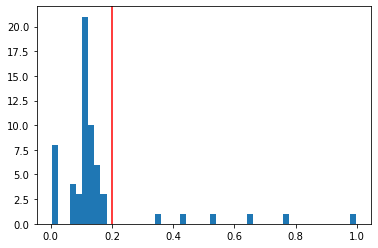

In [101]:
#As we can see most columns with missing values have 0.2 or less
#added red line as the 0.2 threshold
nmissing = df.isna().sum()/df.shape[0] 
nmissing = nmissing[nmissing > 0]

plt.hist(nmissing,bins=50);
plt.axvline(x=0.2, color='red');

In [102]:
#Too many missing values (Outlier Columns)
#Tbese are tbe columns over 20%
columns_over20 = nmissing[nmissing > 0.2].sort_values(ascending = False)
columns_over20

TITEL_KZ        0.997576
AGER_TYP        0.769554
KK_KUNDENTYP    0.655967
KBA05_BAUMAX    0.534687
GEBURTSJAHR     0.440203
ALTER_HH        0.348137
dtype: float64

In [103]:
#before dropping the outlier columns
df.shape

(891221, 85)

In [104]:
#Outliers dropped
df.drop(columns=columns_over20.index, inplace=True)
df.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

The majority of the columns that had missing values had below 20% missing values. I considered below 20% a reasonable amount. It is possible that if we did further analysis we could find columns that appeared to have more than others within that range. However, I focused on the 6 columns with over 20% missing values. We can see them as outliers or single points in that bar graph while the others are close to the majority. I focused on them and removed those columns.

#### Step 1.1.3: Assess Missing Data in Each Row

Here is a histogram of missing values by rows.

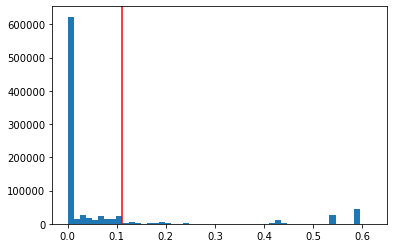

In [105]:
# after some experimentation I added a threshold line at 0.11
nmissing_rows = df.isnull().mean(axis=1)
plt.hist(nmissing_rows,bins=50);
plt.axvline(x=0.11, color='red')

In [106]:
#split rows by ones with too many missing vs less 
threshhold = 0.11

df_lowna = df.loc[nmissing_rows < threshhold, :]
df_highna = df.loc[nmissing_rows > threshhold, :]

print("Percentage of rows with less missing values {}.".format(df_lowna.shape[0]/df.shape[0]) )
print("Percentage of rows with more missing values {}.".format(df_highna.shape[0]/df.shape[0]) )

Percentage of rows with less missing values 0.8658918494963651.
Percentage of rows with more missing values 0.1341081505036349.


In [107]:
# COlumns with no missing values
col_no_missing = df.columns [ (df.isna().sum() == 0) ]
col_no_missing

Index(['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'ZABEOTYP'],
      dtype='object')

Here is a series of bar graphs comparing the different distribution of values of the columns with no missing values

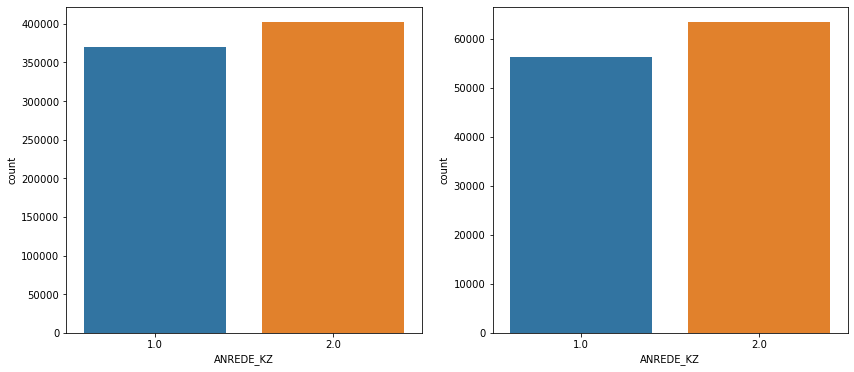

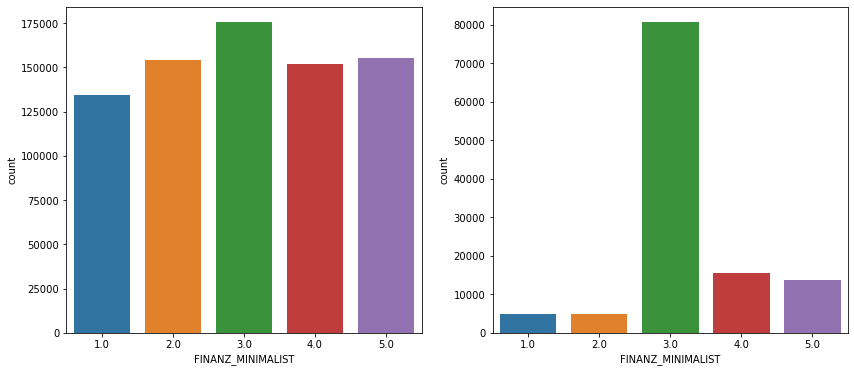

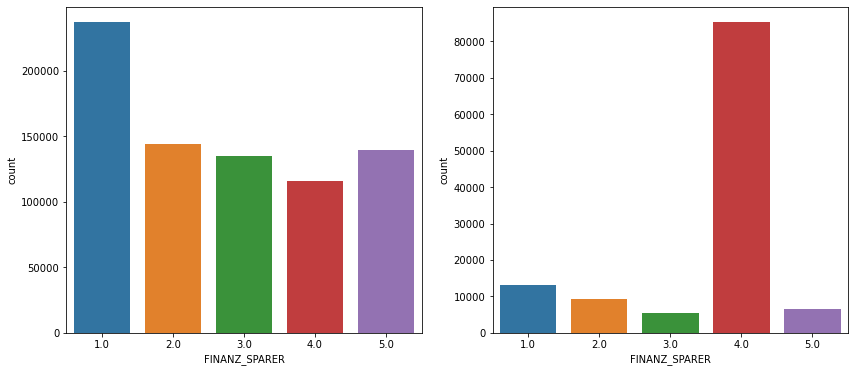

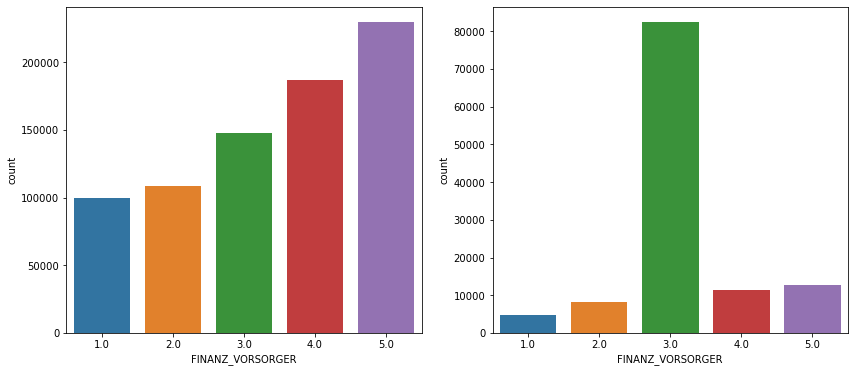

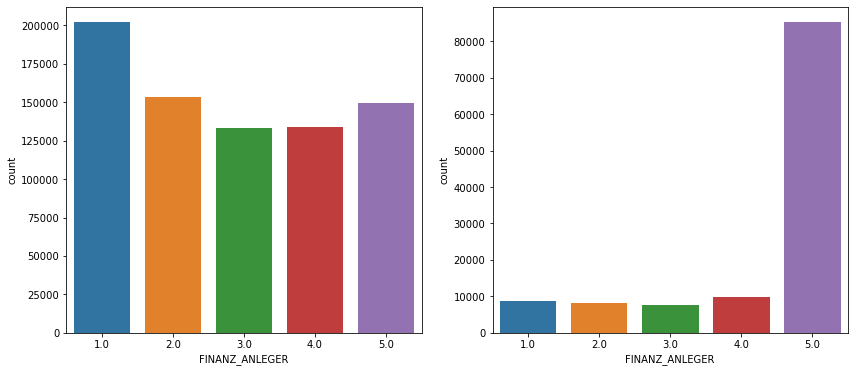

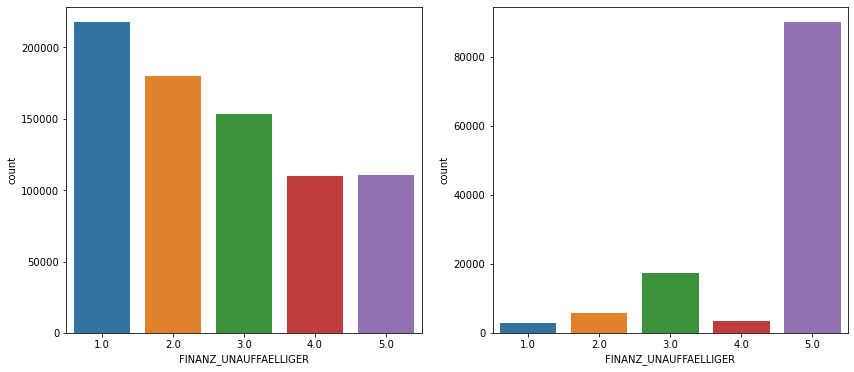

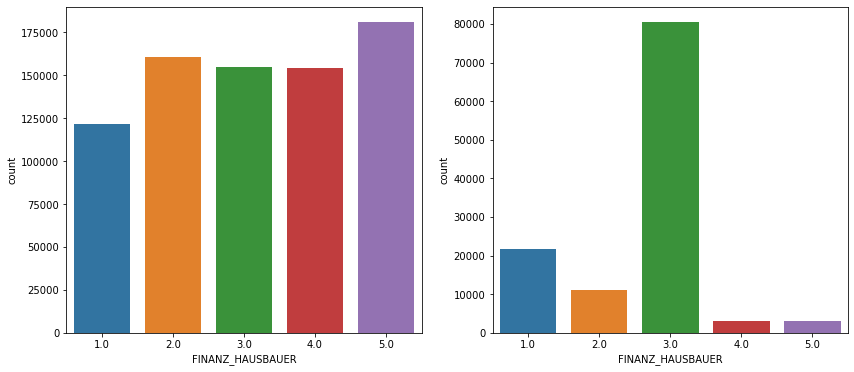

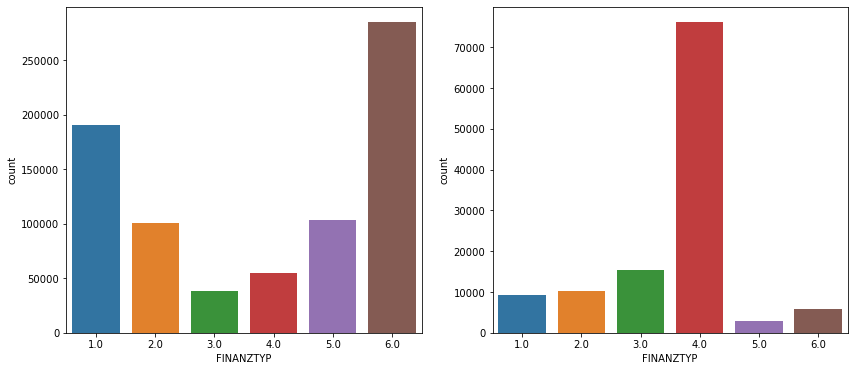

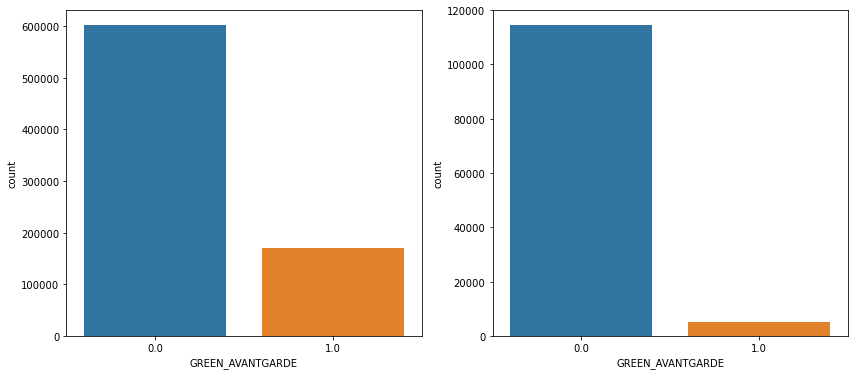

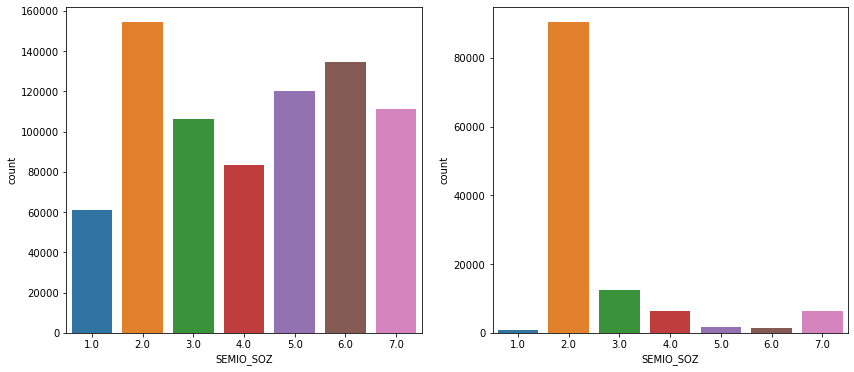

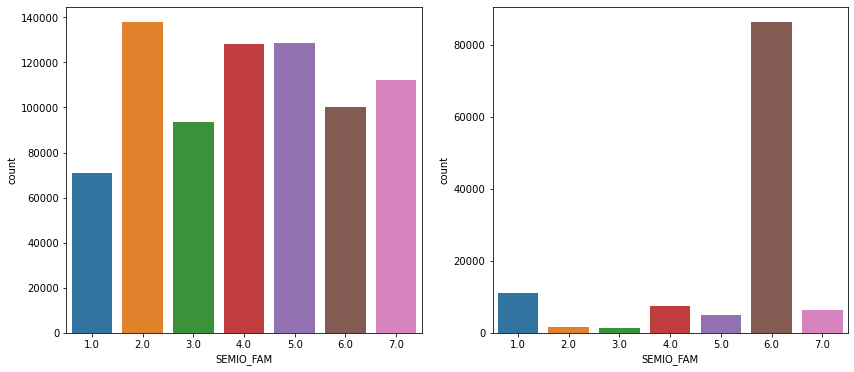

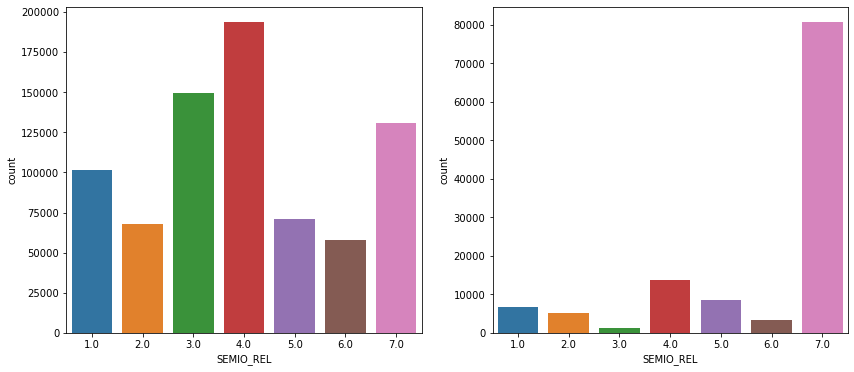

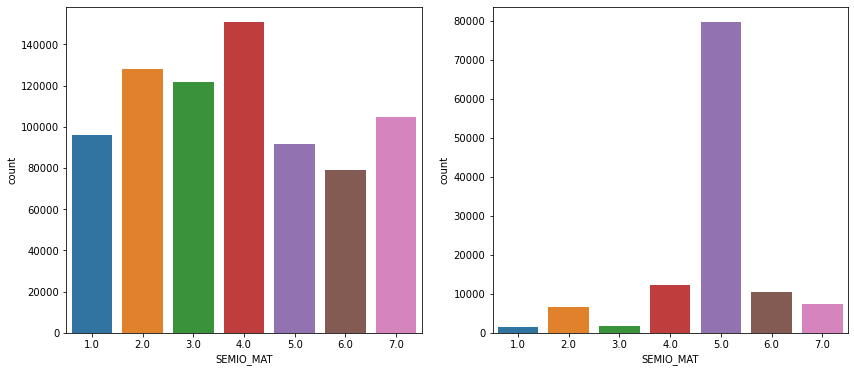

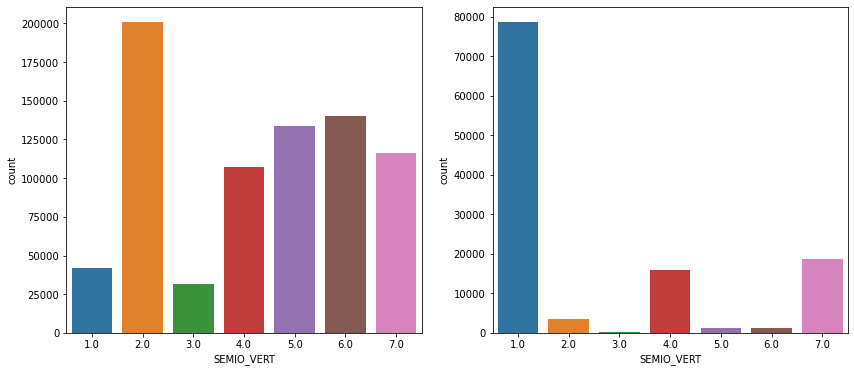

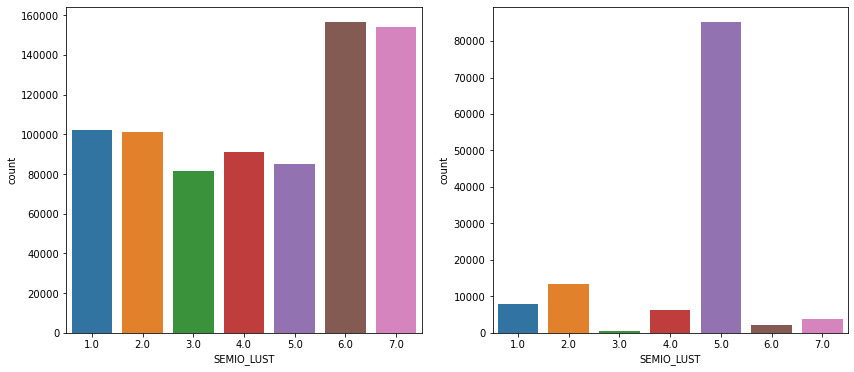

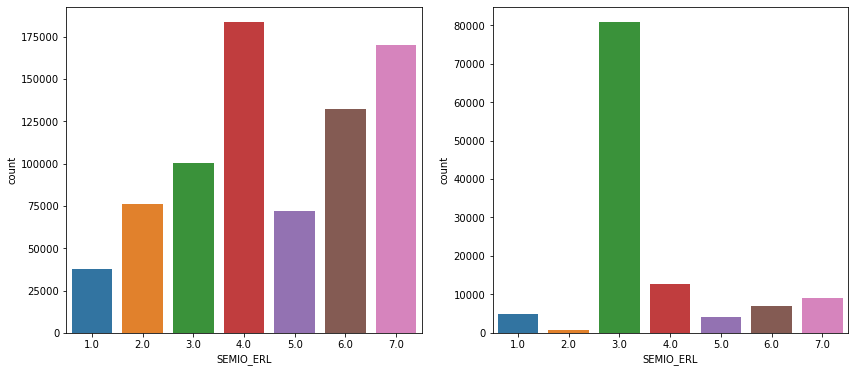

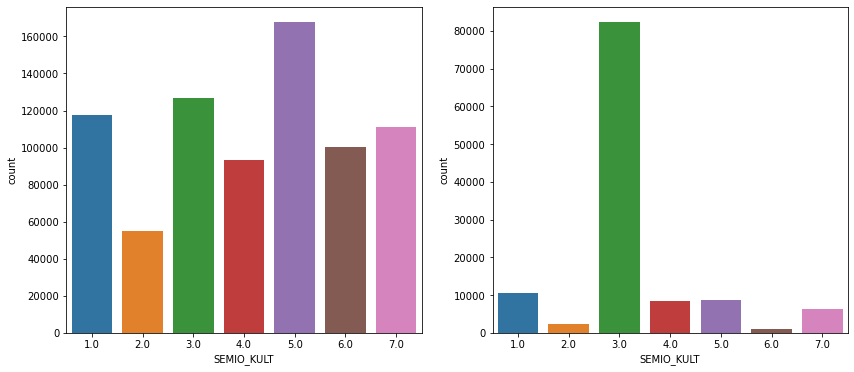

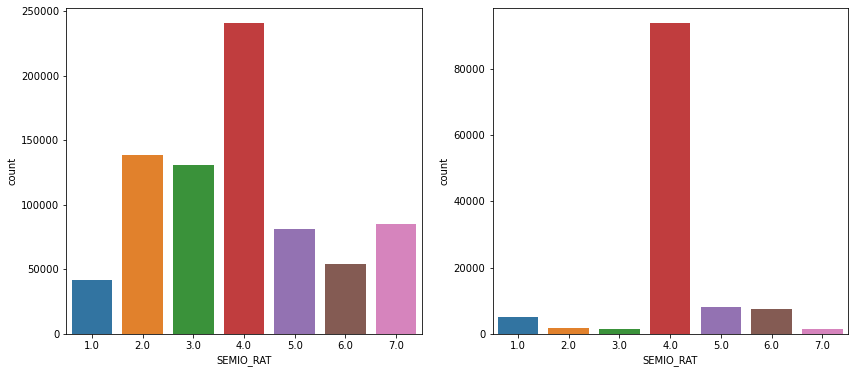

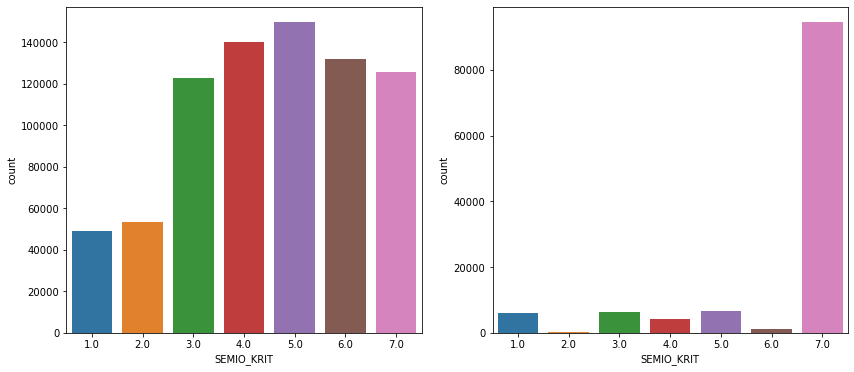

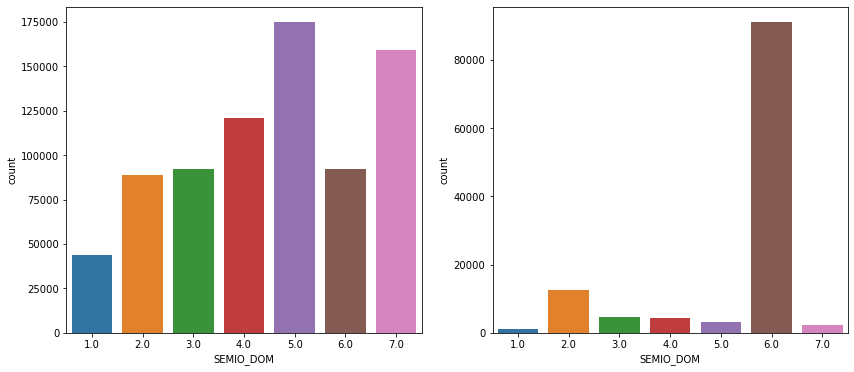

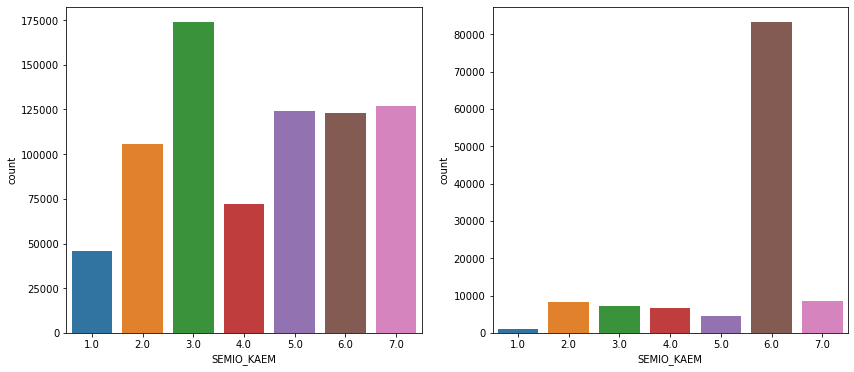

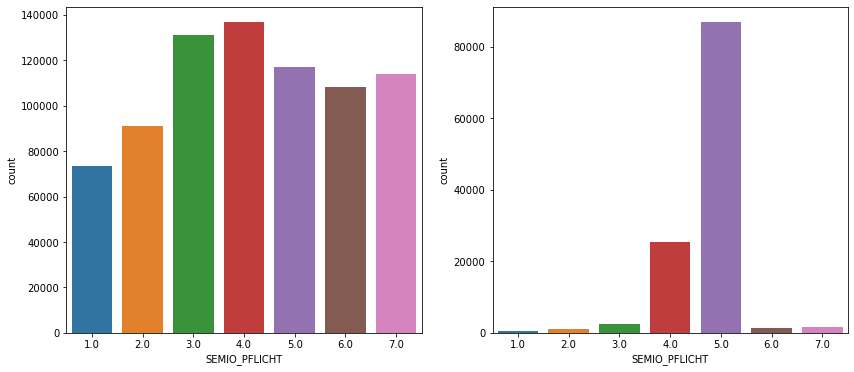

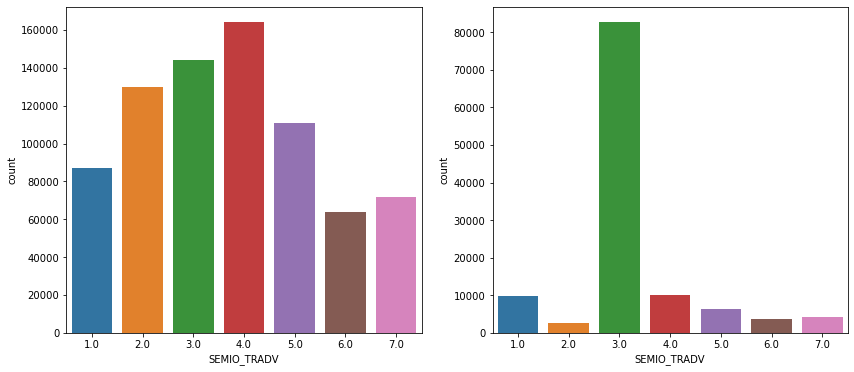

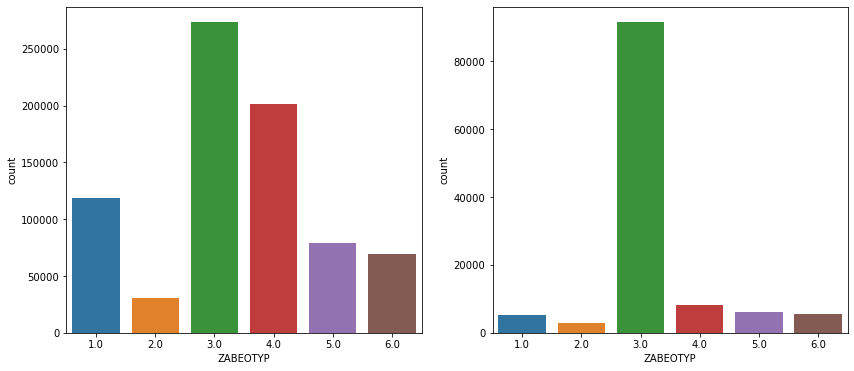

In [108]:
#remove the warnings 
import warnings
warnings.filterwarnings('ignore')

for col in col_no_missing:
    fig, axes = plt.subplots(1,2, figsize=(14, 6));
    sns.countplot(df_lowna[col], ax=axes[0]);
    sns.countplot(df_highna[col], ax=axes[1]);

It seems pretty clear after looking at all these graphs side-by-side that there is a difference in distribution between rows with less missing and rows with many.

Now lets run a Chi Squared to se how likely these differences are

In [109]:
from scipy.stats import chisquare
for col in col_no_missing:
    print(str(col) + ' P-value: ', end='')
    print(chisquare(df_highna[col].value_counts().sort_index(),
                    df_lowna[col].value_counts().sort_index(),
                    axis=0).pvalue, '\n')

ANREDE_KZ P-value: 0.0 

FINANZ_MINIMALIST P-value: 0.0 

FINANZ_SPARER P-value: 0.0 

FINANZ_VORSORGER P-value: 0.0 

FINANZ_ANLEGER P-value: 0.0 

FINANZ_UNAUFFAELLIGER P-value: 0.0 

FINANZ_HAUSBAUER P-value: 0.0 

FINANZTYP P-value: 0.0 

GREEN_AVANTGARDE P-value: 0.0 

SEMIO_SOZ P-value: 0.0 

SEMIO_FAM P-value: 0.0 

SEMIO_REL P-value: 0.0 

SEMIO_MAT P-value: 0.0 

SEMIO_VERT P-value: 0.0 

SEMIO_LUST P-value: 0.0 

SEMIO_ERL P-value: 0.0 

SEMIO_KULT P-value: 0.0 

SEMIO_RAT P-value: 0.0 

SEMIO_KRIT P-value: 0.0 

SEMIO_DOM P-value: 0.0 

SEMIO_KAEM P-value: 0.0 

SEMIO_PFLICHT P-value: 0.0 

SEMIO_TRADV P-value: 0.0 

ZABEOTYP P-value: 0.0 



As we can see all the p-values end up rounding to 0. This means that all these diffences are statistically significant. As a result we should drop the ones with high missing.

In [110]:
#drop all the rows with high missing
df = df_lowna

#### Discussion 1.1.3: Assess Missing Data in Each Row

As we can see the rows with higher number of missing values have vastly different distributions for all the different columns we tested. We tested the columns with no missing values. When putting the distributions side-by-side you can see a huge difference between the low-missing value rows and high missing value rows.

Also, when we ran a Chi-squared distribution on the different column distributions, we found that for all the different columns, we had a p-value of 0. This shows that there is a very low chance that the difference in the distributions are due to random chance.

### Step 1.2: Select and Re-Encode Features

Lets see the different column types.

In [111]:
feat_info.type.value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [112]:
#these are the categorical variables
categorical = feat_info [ feat_info.type == 'categorical' ]
categorical

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


Though we removed certain outlier columns from the big dataframe we did not remove them from the feat_info dataframe.

In [113]:
#there seems to be 3 categorical variables that are named differently in the feat_info and azdias
set_of_cols = set(df.columns)
cols = [ c for c in categorical.attribute if c in set_of_cols]
print("Only {} out of {} columns listed in feat_info actually exist in the dataframe right now".format(len(cols), len(categorical.attribute)))

Only 18 out of 21 columns listed in feat_info actually exist in the dataframe right now


In [114]:
#what are those 3 columns
not_in_cols = [ c for c in categorical.attribute if c not in set_of_cols]
not_in_cols

['AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP']

In [115]:
#6 outlier columns we removed
columns_over20

TITEL_KZ        0.997576
AGER_TYP        0.769554
KK_KUNDENTYP    0.655967
KBA05_BAUMAX    0.534687
GEBURTSJAHR     0.440203
ALTER_HH        0.348137
dtype: float64

#### Step 1.2.1: Re-Encode Categorical Features

Here I explored the 18 different categorical features. 

How many different values do each categorical columns have

In [116]:
#Used 5 as th threshold
#Any column with more than 5 was too much for me to process
col_under_6 = [col for col in cols if len(df[col].value_counts()) < 6]
for col in cols :
    print(str(col) + ': ', end='')
    print(len(df[col].value_counts()))
col_under_6

ANREDE_KZ: 2
CJT_GESAMTTYP: 6
FINANZTYP: 6
GFK_URLAUBERTYP: 12
GREEN_AVANTGARDE: 2
LP_FAMILIE_FEIN: 11
LP_FAMILIE_GROB: 5
LP_STATUS_FEIN: 10
LP_STATUS_GROB: 5
NATIONALITAET_KZ: 3
SHOPPER_TYP: 4
SOHO_KZ: 2
VERS_TYP: 2
ZABEOTYP: 6
GEBAEUDETYP: 7
OST_WEST_KZ: 2
CAMEO_DEUG_2015: 9
CAMEO_DEU_2015: 44


['ANREDE_KZ',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_GROB',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'OST_WEST_KZ']

In [117]:
df[col_under_6].dtypes

ANREDE_KZ           float64
GREEN_AVANTGARDE    float64
LP_FAMILIE_GROB     float64
LP_STATUS_GROB      float64
NATIONALITAET_KZ    float64
SHOPPER_TYP         float64
SOHO_KZ             float64
VERS_TYP            float64
OST_WEST_KZ          object
dtype: object

In [118]:
#Before processing, have to create dataframe of the categorical variables
#have to object datatype
#originally encoded as float64
df_cat_u6 = df[col_under_6]
for col in col_under_6 :
    df_cat_u6[col] = df_cat_u6[col].astype(object)
df_cat_u6.dtypes

ANREDE_KZ           object
GREEN_AVANTGARDE    object
LP_FAMILIE_GROB     object
LP_STATUS_GROB      object
NATIONALITAET_KZ    object
SHOPPER_TYP         object
SOHO_KZ             object
VERS_TYP            object
OST_WEST_KZ         object
dtype: object

In [119]:
#shape with all the categorical columns
df_cat_u6.shape

(771701, 9)

Instead of looking at every single column, I decied to make dummy columns for all the categorical variables.

In [120]:
#will make the dummy variables out of the 6 and under columns
categorical_dummy = pd.get_dummies(df_cat_u6, drop_first=True) 
#can drop the first to save space
categorical_dummy.shape

(771701, 18)

In [121]:
categorical_dummy

,ANREDE_KZ_2.0,GREEN_AVANTGARDE_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_1.0,VERS_TYP_2.0,OST_WEST_KZ_W
1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1
2,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
3,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
4,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,1
5,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
891217,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
891218,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
891219,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1


Now I will replace the original categorical columns with either their dummy columns or remove them from analysis.

In [122]:
df.shape

(771701, 79)

In [123]:
#dropped the 18 categorical variables
df2 = df.drop(columns=cols)
df2.shape

(771701, 61)

In [124]:
df = pd.concat([df2, categorical_dummy], axis=1)
df.shape

(771701, 79)

#### Discussion 1.2.1: Re-Encode Categorical Features

Because there were 18+ categorical variables each with their own different encoding, to save time I looked at the different levels of each categorical variable. I used my discretion on what to do with the categorical variable. Obviously for binary columns, I kept them and made them dummies. For others if the column had 5 or less types I kept the column for analysis and made dummy columns.

#### Step 1.2.2: Engineer Mixed-Type Features

In [125]:
#these are the mixed variables
mixed = feat_info [ feat_info.type == 'mixed' ]
mixed

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1, 0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1, 0]"


Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

In [126]:
"""
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)
"""
df['PRAEGENDE_JUGENDJAHRE'].unique()

array([14., 15.,  8.,  3., 10., 11.,  5.,  9.,  6.,  4., nan,  2.,  1.,
       12., 13.,  7.])

Extracted the decade out of the PRAEGENDE_JUGENDJAHRE column

In [127]:
def get_decade(i) :
    """
    inputs :
    i - integer
    output :
    the correct decade according to the dictionary under PRAEGENDE_JUGENDJAHRE
    single digit integers representing the decade (4: 40s, 5: 50s, 6: 60s, etc.)
    -helper function
    """
    if i in [1, 2] :
        return 4
    if i in [3, 4] :
        return 5
    if i in [5, 6, 7] :
        return 6
    if i in [8, 9] :
        return 7
    if i in [10, 11, 12, 13] :
        return 8
    if i in [14, 15] :
        return 9
    else : 
        return np.nan
df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(get_decade)

Extracted whether or not the movement was Avangarde or not out of the PRAEGENDE_JUGENDJAHRE column.

In [128]:
def in_avangarde(i) :
    """
    inputs :
    i - integer
    output :
    1 if the movement is avangarde and 0 if the movement is mainstream
    all NaN left as NaN
    -looked at the dictionary under PRAEGENDE_JUGENDJAHRE
    """
    mainstream = [1, 3, 5, 8, 12, 14]
    avantgarde = [2, 4, 6, 7, 9, 13, 15]
    if (i in avantgarde) :
        return 1
    if (i in mainstream) :
        return 0
    return None

df['AVANGARDE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(in_avangarde)

In [129]:
#engineered features alongside the original
df[['PRAEGENDE_JUGENDJAHRE', 'DECADE','AVANGARDE_MOVEMENT']].head(10)

,PRAEGENDE_JUGENDJAHRE,DECADE,AVANGARDE_MOVEMENT
1,14.0,9.0,0.0
2,15.0,9.0,1.0
3,8.0,7.0,0.0
4,8.0,7.0,0.0
5,3.0,5.0,0.0
6,10.0,8.0,NaN
7,8.0,7.0,0.0
8,11.0,8.0,NaN
9,15.0,9.0,1.0
10,3.0,5.0,0.0


Investigate "CAMEO_INTL_2015" and engineer two new variables

In [130]:
"""
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


"CAMEO_INTL_2015" combines information on two axes: wealth and life stage. 
Break up the two-digit codes by their 'tens'-place and 'ones'-place digits 
into two new ordinal variables (which, for the purposes of this project, 
is equivalent to just treating them as their raw numeric values).
"""
df['CAMEO_INTL_2015'].unique()

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', '25', nan, '23', '31', '52', '35', '45', '44', '32'],
      dtype=object)

In [131]:
#feature engineering functions
def extract_poor(s) :
    """
    inputs :
    i - string type programatically but actually 2-digit number
    output :
    Extracts how poor the family is (represented by first digit)
    -looked at the dictionary under CAMEO_INTL_2015
    """
    if type(s) == str :
        return float(s[0])
    return s

def extract_age(s) :
    """
    inputs :
    i - string type programatically but actually 2-digit number
    output :
    Extracts family age (represented by second digit)
    -looked at the dictionary under CAMEO_INTL_2015
    """
    if type(s) == str :
        return float(s[1])
    return s

#Engineer the different features
df['HOUSEHOLD_POVERTY'] = df['CAMEO_INTL_2015'].apply(extract_poor)
df['HOUSEHOLD_AGE'] = df['CAMEO_INTL_2015'].apply(extract_age)

#See newly engineered features alongside original feature
df[['CAMEO_INTL_2015', 'HOUSEHOLD_POVERTY', 'HOUSEHOLD_AGE']].head(10)

,CAMEO_INTL_2015,HOUSEHOLD_POVERTY,HOUSEHOLD_AGE
1,51,5.0,1.0
2,24,2.0,4.0
3,12,1.0,2.0
4,43,4.0,3.0
5,54,5.0,4.0
6,22,2.0,2.0
7,14,1.0,4.0
8,13,1.0,3.0
9,15,1.0,5.0
10,51,5.0,1.0


In [132]:
mixed_columns = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']

In [133]:
#Wanted to see how many different types the other mixed variables had
for col in mixed_columns :
    print(col, end=': ')
    print( len(df[col].unique()) )

PRAEGENDE_JUGENDJAHRE: 16
CAMEO_INTL_2015: 22
LP_LEBENSPHASE_FEIN: 41
LP_LEBENSPHASE_GROB: 13
WOHNLAGE: 8
PLZ8_BAUMAX: 6


In [134]:
df['PLZ8_BAUMAX'].unique()

array([ 1.,  2., nan,  4.,  5.,  3.])

In [135]:
#not too many levels so I decided to make dummy columns
df['PLZ8_BAUMAX'].unique()
temp_df = df[['PLZ8_BAUMAX']]
temp_df['PLZ8_BAUMAX'] = temp_df['PLZ8_BAUMAX'].astype('object')
temp_df = pd.get_dummies(temp_df)
temp_df.columns = ['1to2_FAMILY_HOMES', '3to5_FAMILY_HOMES', 
                   '6to10_FAMILY_HOMES', 'OVER_10_FAMILY_HOMES', 'BUSINESS_BUILDINGS'
                  ]
df = pd.concat([df, temp_df], axis=1)

In [136]:
df.drop(columns=mixed_columns, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Using PRAEGENDE_JUGENDJAHRE, I engineered 2 new variables (the decade and whether the movement is avangarde

Using CAMEO_INTL_2015, I engineered 2 new variabls (household age andd household poverty).

I saw that all the other mixed variables were too mixed and complicated for me to come up with good structures. I did see that the PLZ8_BAUMAX had only 6 different values. As a result I thought it was worth it to convert it into dummy columns.

For the others I just dropped them.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [137]:
"""
In this clean method I used HELPER FUNCTIONS. 
To see more details in these helper functions,
scroll up. The helper functions are:
-convert
-create_list
-get_decade
-in_avangarde
"""

def clean_data(df, cthreshold=0.2):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    #Convert these strings to list of int & string 
    #feat_info.missing_or_unknown = feat_info.missing_or_unknown.apply(create_list)
    missing_data_dict = dict(zip(feat_info.attribute, feat_info.missing_or_unknown))
    # Identify missing or unknown data values and convert them to NaNs.
    for col in missing_data_dict.keys(): 
        df.loc[df[col].isin(missing_data_dict[col]), col] = np.nan
    
    #GETTING OUTLIER COLUMNS (COLUMNS WITH MORE THAN 20% MISSING)
    nmissing = df.isna().sum()/df.shape[0] 
    nmissing = nmissing[nmissing > 0]
    columns_over = nmissing[nmissing > cthreshold].sort_values(ascending = False)
    #Drop outlier columns
    df.drop(columns=columns_over.index, inplace=True)
    
    #Identify rows with lots of missing (11% is the threshold I chose)
    #Any row with more got removed
    nmissing_rows = df.isnull().mean(axis=1)
    threshold = 0.11
    df = df.loc[nmissing_rows < threshold, :]
    
    #Identify categorical variables
    categorical = feat_info [ feat_info.type == 'categorical' ]
    #some were removed earlier so find the ones that were not
    set_of_cols = set(df.columns)
    cols = [ c for c in categorical.attribute if c in set_of_cols]
    #identify the columns with less number of unique values
    col_under_6 = [col for col in cols if len(df[col].value_counts()) < 6]
    #convert columns to object type
    df_cat_u6 = df[col_under_6]
    for col in col_under_6 :
        df_cat_u6[col] = df_cat_u6[col].astype(object)
    #will make the dummy variables out of the 6 and under columns
    categorical_dummy = pd.get_dummies(df_cat_u6, drop_first=True) 
    #can drop the first to save space
    #dropped the 18 categorical variablees
    df2 = df.drop(columns=cols)
    #add the dummy variables
    df = pd.concat([df2, categorical_dummy], axis=1)
    
    #these are the mixed variables
    mixed_columns = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']
    #Extract decade and avangarde columns from PRAEGENDE_JUGENDJAHRE
    df['AVANGARDE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(in_avangarde)
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(get_decade)
    #Extract household poverty and household age from CAMEO_INTL_2015
    df['HOUSEHOLD_POVERTY'] = df['CAMEO_INTL_2015'].apply(extract_poor)
    df['HOUSEHOLD_AGE'] = df['CAMEO_INTL_2015'].apply(extract_age)
    #PLZ8_BAUMAX not too many unique values so I decided to make dummy columns
    temp_df = df[['PLZ8_BAUMAX']]
    temp_df['PLZ8_BAUMAX'] = temp_df['PLZ8_BAUMAX'].astype('object')
    temp_df = pd.get_dummies(temp_df)
    temp_df.columns = ['1to2_FAMILY_HOMES', '3to5_FAMILY_HOMES', 
                       '6to10_FAMILY_HOMES', 'OVER_10_FAMILY_HOMES', 'BUSINESS_BUILDINGS'
                      ]
    df = pd.concat([df, temp_df], axis=1)
    #drop all the mixed columns after adding the engineered ones
    df.drop(columns=mixed_columns, inplace=True)
    return df


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

In [138]:
#there are a lot of missing values
#in order to feature scale we need to get rid of the missing value
sum(df.isna().sum())

572897

In [139]:
#Here I just subsituted the missing values with most frequent
from sklearn.impute import SimpleImputer
saved_columns = df.columns
imp = SimpleImputer(strategy="most_frequent")
fitted_imp = imp.fit(df)
imputed_values = fitted_imp.transform(df)
imputed_df = pd.DataFrame(imputed_values, columns=saved_columns)
imputed_df.shape

(771701, 82)

In [140]:
#no more missing values
sum(imputed_df.isna().sum())

0

In [141]:
# Before PCA one of the steps is features scaling
#modify the values of dataframe so that mean=0 and std=1
from sklearn.preprocessing import StandardScaler

scaler_fitted = StandardScaler().fit(imputed_df.values)
scaled_vals = scaler_fitted.transform(imputed_df.values)
scaled_vals.shape

(771701, 82)

### Discussion 2.1: Apply Feature Scaling

I used the StandardScaler. This is used to modify the values of the dataframe so that the mean=0 and the standard deviation=1.

Luckily all the data types were float making it perfect for StandardScaler.

Before performing feature scaling, I imputted the missing values. I did this by subsituting missing values with the most frequent value in the column.

### Step 2.2: Perform Dimensionality Reduction

Doing PCA without specifying the number of components. As a result, it ends up having the same number of components as  the length of the dataframe.

In [142]:
from sklearn.decomposition import PCA
def do_pca_default(scaled_vals):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
            -number of components not set so will end up being same length as df
    '''
    pca = PCA()
    X_pca = pca.fit_transform(scaled_vals)
    return pca, X_pca

pca, X_pca = do_pca_default(scaled_vals)
pca, X_pca

(PCA(),
 array([[ 3.21719502e+00, -2.98665974e+00, -3.26689975e+00, ...,
         -1.57503575e-01, -1.54731265e-01, -2.01609924e-03],
        [-9.69527866e-01,  2.70716610e-01, -3.31286166e+00, ...,
          1.09563929e-01,  8.95307381e-02, -1.66098925e-03],
        [-3.94200538e+00,  1.49027316e+00, -5.42765705e-01, ...,
          1.21420106e-01, -6.45381021e-01, -4.11089285e-02],
        ...,
        [-1.17606707e+00, -3.23121280e+00, -3.12465968e+00, ...,
          7.18910987e-02, -1.41387017e-01, -1.66037475e-02],
        [ 5.81642261e+00, -3.61292041e+00,  2.47269628e+00, ...,
         -9.48539496e-02,  1.68702742e-01, -1.80509883e-01],
        [-6.98803885e-01,  1.03235170e+00,  2.68756033e+00, ...,
         -6.95759279e-01, -2.77261861e-01, -2.73299917e-02]]))

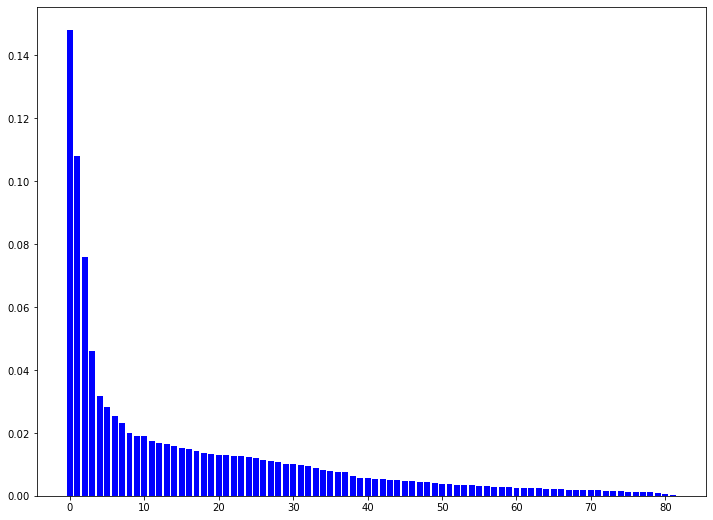

In [143]:
vals = pca.explained_variance_ratio_
fig, ax = plt.subplots(figsize=(12,9))
plt.bar(np.arange(len(vals)), vals, color='b');

The red lines shows the points that in my opinion stood out.

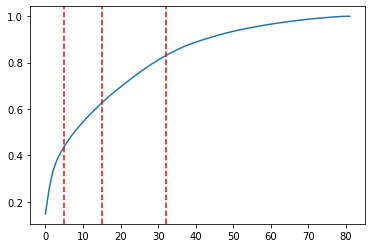

In [144]:
#Mapping the components by cumulitive variance ratio
vals = np.cumsum(pca.explained_variance_ratio_)
plt.plot(vals);
plt.axvline(x=5, color='red', linestyle='dashed')
plt.axvline(x=15, color='red', linestyle='dashed')
plt.axvline(x=32, color='red', linestyle='dashed')

In [145]:
def do_pca(n_components, scaled_vals):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: data - the data you would like to transform
           n_components - number of components 

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    pca = PCA(n_components)
    X_pca = pca.fit_transform(scaled_vals)
    return pca, X_pca

In [146]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_32, X_pca_32 = do_pca(32, scaled_vals)

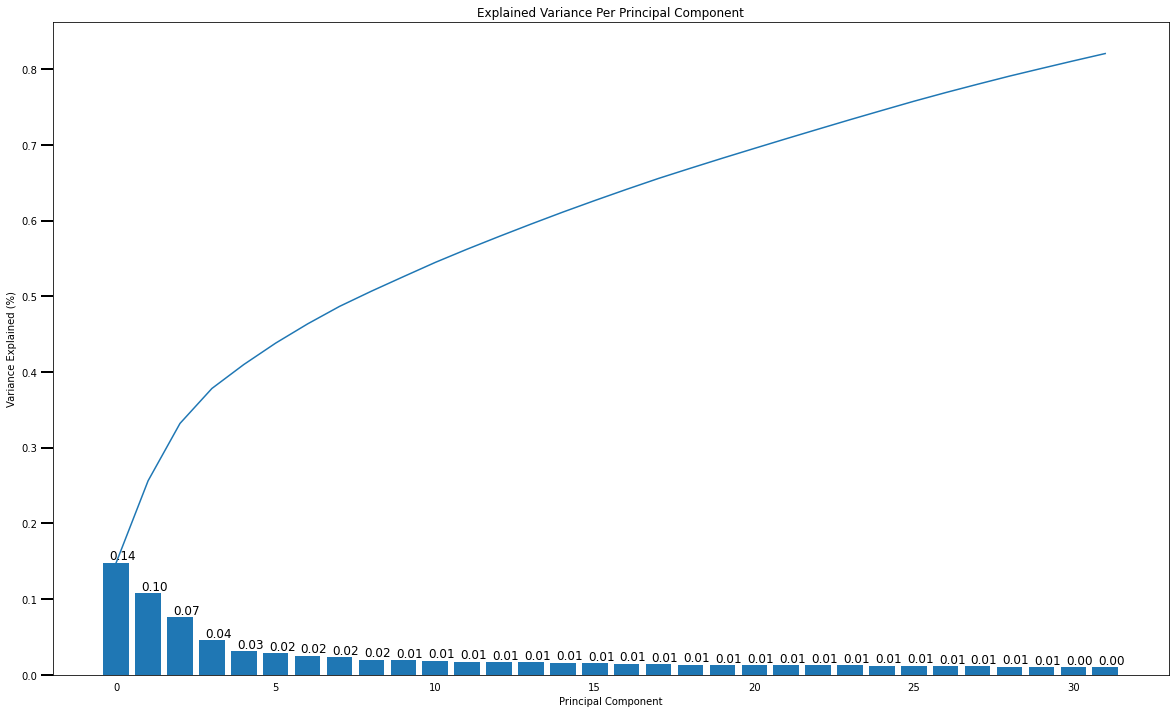

In [147]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 12))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(((str(vals[i])[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca_32)

### Discussion 2.2: Perform Dimensionality Reduction

Thre seems to be a stabilization around component 15 as far as the decrease in cumulitive variance and cumulitive variance explained so far.

In [148]:
np.cumsum(pca.explained_variance_ratio_[:15])[-1]

0.6111824905123175

### Fit a Final Dimensional Reduction

In [149]:
#finalized at 15 so performed PCA on the scaled values 
#reduces data from 82 columns to 15
from sklearn.decomposition import PCA
n_components = 15 
pca_final = PCA(n_components)
fitted_pca = pca_final.fit(scaled_vals)
pca_15 = fitted_pca.transform(scaled_vals)
pca_15.shape

(771701, 15)

### Step 2.3: Interpret Principal Components

In [150]:
def map_component_weights(component_num, pca, df=df) :
    """
    INPUT: component_num: which component in the pca
           pca: pca array (reduced version of dataframe)
    OUTPUT: prints the 5 highest positive and 5 most negatively correlated features to that component
            also prints a bar graph with those 10 features and their correlation
    """
    component_map = pd.DataFrame(np.round(pca.components_, 4), columns=df.columns)
    component_1 = component_map.iloc[component_num-1].sort_values(ascending=False).iloc[np.r_[0:5, -5:0]]
    print(component_1)
    df_temp = pd.DataFrame({'features': component_1.index, 'feature_weight': component_1.values})
    df_temp.plot.barh(x='features', y='feature_weight', rot=0);

PLZ8_ANTG3            0.2222
PLZ8_ANTG4            0.2142
HOUSEHOLD_POVERTY     0.1976
HH_EINKOMMEN_SCORE    0.1933
ORTSGR_KLS9           0.1908
KBA05_GBZ            -0.2070
KBA05_ANTG1          -0.2082
1to2_FAMILY_HOMES    -0.2161
MOBI_REGIO           -0.2198
PLZ8_ANTG1           -0.2228
Name: 0, dtype: float64


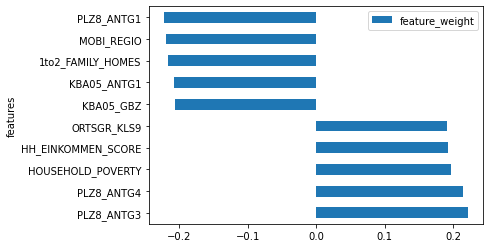

In [151]:
map_component_weights(1, pca_final)

ALTERSKATEGORIE_GROB    0.2653
FINANZ_VORSORGER        0.2373
SEMIO_ERL               0.2297
SEMIO_LUST              0.1853
RETOURTYP_BK_S          0.1622
SEMIO_TRADV            -0.2342
SEMIO_PFLICHT          -0.2367
FINANZ_SPARER          -0.2449
DECADE                 -0.2482
SEMIO_REL              -0.2616
Name: 1, dtype: float64


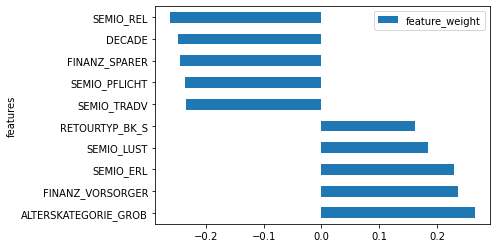

In [152]:
map_component_weights(2, pca_final)

SEMIO_VERT           0.3422
SEMIO_SOZ            0.2623
SEMIO_FAM            0.2489
SEMIO_KULT           0.2331
FINANZ_MINIMALIST    0.1580
SEMIO_RAT           -0.2092
SEMIO_KRIT          -0.2702
SEMIO_DOM           -0.3091
SEMIO_KAEM          -0.3337
ANREDE_KZ_2.0       -0.3638
Name: 2, dtype: float64


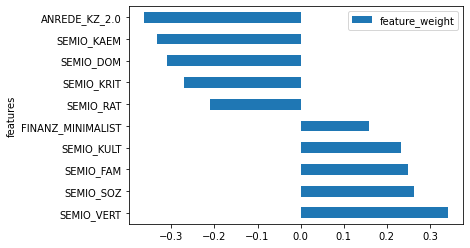

In [153]:
map_component_weights(3, pca_final)

### Discussion 2.3: Interpret Principal Components


#### Component 1
Factors with the most positive correlation on component 1 include PLZ8_ANTG3, PLZ8_ANTG4, HOUSEHOLD_POVERTY, HH_EINKOMMEN_SCORE, and ORTSGR_KLS9.

Factors with the most negative correlation on component 1 include PLZ8_ANTG1, MOBI_REGIO, 1to2_FAMILY_HOMES, KBA05_ANTG1, KBA05_GBZ.


From the factors above, we can infer that component 1 is highly correlated with lower income, high population density, less 1-2 family homes, more 6-10 family homes, less infrastructure. Overall this component seems to correlate with low socioeconomic status.

#### Component 2
Factors with the most positive correlation on component 2 include ALTERSKATEGORIE_GROB, FINANZ_VORSORGER, SEMIO_ERL, SEMIO_LUST, and RETOURTYP_BK_S.

Factors with the most negative correlation on component 2 include SEMIO_REL, DECADE, FINANZ_SPARER, SEMIO_PFLICHT, and SEMIO_TRADV.

From the factors above, we can infer that component 2 is highly correlated with older, less modern, more religious, more fiscally conservative and traditional. Less sensual and basically minimalist shoppers. 

#### Component 3 
Factors with the most positive correlation on component 3 include SEMIO_VERT, SEMIO_SOZ, SEMIO_FAM, SEMIO_KULT, and FINANZ_MINIMALIST.

Factors with the most negative correlation on component 2 include SEMIO_RAT, SEMIO_KRIT, SEMIO_DOM, SEMIO_KAEM, and ANREDE_KZ_2.0.

From the factors above we can infer that component 3 is more correlated with being less dreamful, not as socially or culturally minded, being financially minimalist, having a higher affinity for being rational and critical, being more dominant and combative and being predominantly male over female.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

In [154]:
from sklearn.cluster import KMeans

Calculated:  2
Calculated:  3
Calculated:  4
Calculated:  5
Calculated:  6
Calculated:  7
Calculated:  8
Calculated:  9
Calculated:  10
Calculated:  11
Calculated:  12
Calculated:  13
Calculated:  14
Calculated:  15
Calculated:  16
Calculated:  17
Calculated:  18
Calculated:  19


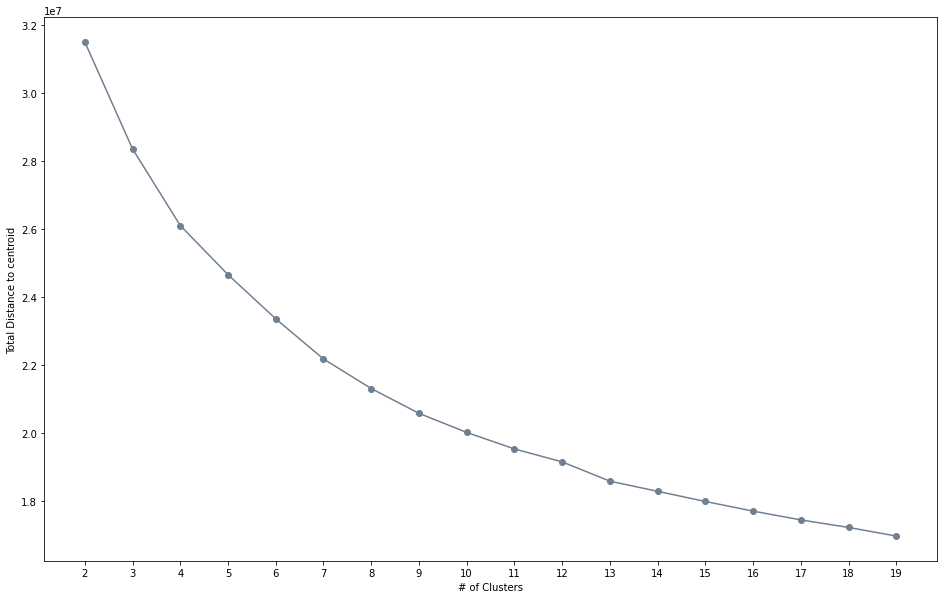

In [155]:
scores = {}
for k in range(2, 20):
    # run k-means clustering on the data and...
    scores[k] = np.abs(KMeans(n_clusters=k).fit(pca_15).score(pca_15))
    print('Calculated: ', k)

# Plot relationship plot
fig, ax = plt.subplots(figsize=(16,10))    
ax = pd.Series(scores).plot(marker='o', color='slategray')
ax.set_xticks(np.arange(2, 20), minor=False);  
ax.set_xlabel("# of Clusters")
ax.set_ylabel("Total Distance to centroid");

I chose k=10 as the final number of clusters. 

In [156]:
k=10
kmeans = KMeans(n_clusters=k, random_state=1).fit(pca_15)

In [157]:
kmeans.cluster_centers_.shape

(10, 15)

### Discussion 3.1: Apply Clustering to General Population

I see an elbow around k=10 where the curve definitely become less steap and an elbow around k=13 where the curve completely flattens. 

I chose k=10.

### Step 3.2: Apply All Steps to the Customer Data

In [158]:
# Load in the customer demographics data.
df2 = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
#clean customer data
df2 = clean_data(df2, cthreshold=0.35)
df2.shape

(135799, 82)

In [159]:
#impute customer data
saved_columns = df2.columns
#re-use the fitted imputation object
imputed_values2 = fitted_imp.transform(df2)
imputed_df2 = pd.DataFrame(imputed_values2, columns=saved_columns)
imputed_df2.shape

(135799, 82)

In [160]:
#Rescale the df2 
#re-use the scaler object used for df
scaled_vals2 = scaler_fitted.transform(imputed_df2.values)
scaled_vals2.shape

(135799, 82)

In [161]:
#run PCA by re-using the pca object for df on df2
pca_15_2 = fitted_pca.transform(scaled_vals2)
pca_15_2.shape

(135799, 15)

### Step 3.3: Compare Customer Data to Demographics Data

In [162]:
#Here we predicted each of the points and put them in a cluster
#re-using the fitted kmeans object on df2 
company_results = kmeans.predict(pca_15)
customer_results = kmeans.predict(pca_15_2)
company_results.shape, customer_results.shape

((771701,), (135799,))

In [163]:
length = len(customer_results)
customer_distrib = [list(customer_results).count(i) / length for i in set(customer_results)]

length = len(company_results)
company_distrib = [list(company_results).count(i) / length for i in set(company_results)]

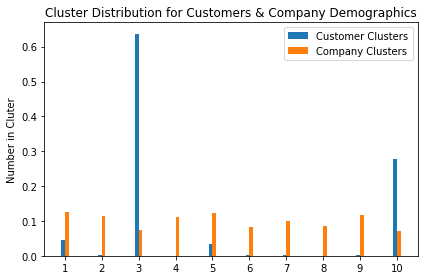

In [164]:
x = np.arange(k)  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, customer_distrib, width, label='Customer Clusters')
rects2 = ax.bar(x + width/2, company_distrib, width, label='Company Clusters')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number in Cluter')
ax.set_title('Cluster Distribution for Customers & Company Demographics')
ax.set_xticks(x)
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

In [165]:
#here we see cluster proportions of the company and company data
customer_values = np.unique(customer_results, return_counts=True)[1]
company_values = np.unique(company_results, return_counts=True)[1]

customer_proportions = customer_values/sum(customer_values)
company_proportions = company_values/sum(company_values)
df_cluster = pd.DataFrame([list(customer_proportions), list(company_proportions)], index=['Customer Cluster Proportions', 'Company Cluster Proportions'])
df_cluster.columns = [1, 2, 3, 4, 5 ,6, 7, 8, 9, 10]
df_cluster

,1,2,3,4,5,6,7,8,9,10
Customer Cluster Proportions,0.044286,0.000920,0.637685,0.000729,0.032806,0.001620,0.002820,0.000353,0.001009,0.277771
Company Cluster Proportions,0.124997,0.113405,0.073280,0.111057,0.122778,0.081519,0.100684,0.084841,0.115865,0.071574


Clusters shown more in the customer data were 3 and 10.

Some clusters shown more in the company were 2 and 9.

SEMIO_VERT           0.3422
SEMIO_SOZ            0.2623
SEMIO_FAM            0.2489
SEMIO_KULT           0.2331
FINANZ_MINIMALIST    0.1580
SEMIO_RAT           -0.2092
SEMIO_KRIT          -0.2702
SEMIO_DOM           -0.3091
SEMIO_KAEM          -0.3337
ANREDE_KZ_2.0       -0.3638
Name: 2, dtype: float64


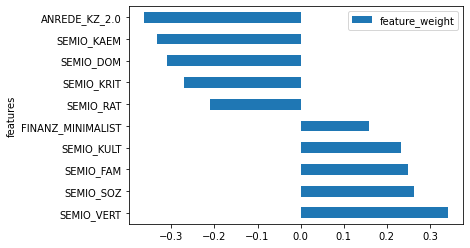

In [173]:
# Which clusters have high customer data?
map_component_weights(3, pca_final)

VERS_TYP_2.0           0.2449
LP_FAMILIE_GROB_5.0    0.2344
SHOPPER_TYP_2.0        0.2162
OST_WEST_KZ_W          0.2050
HEALTH_TYP             0.1764
SEMIO_MAT             -0.1839
LP_FAMILIE_GROB_4.0   -0.1858
SHOPPER_TYP_1.0       -0.2178
LP_STATUS_GROB_4.0    -0.2201
MIN_GEBAEUDEJAHR      -0.3761
Name: 9, dtype: float64


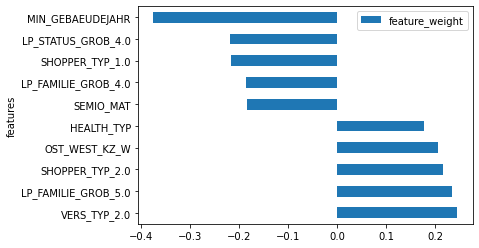

In [174]:
# What kinds of people are part of a cluster that is overrepresented in the
# company data compared to the customer data?
map_component_weights(10, pca_final)

ALTERSKATEGORIE_GROB    0.2653
FINANZ_VORSORGER        0.2373
SEMIO_ERL               0.2297
SEMIO_LUST              0.1853
RETOURTYP_BK_S          0.1622
SEMIO_TRADV            -0.2342
SEMIO_PFLICHT          -0.2367
FINANZ_SPARER          -0.2449
DECADE                 -0.2482
SEMIO_REL              -0.2616
Name: 1, dtype: float64


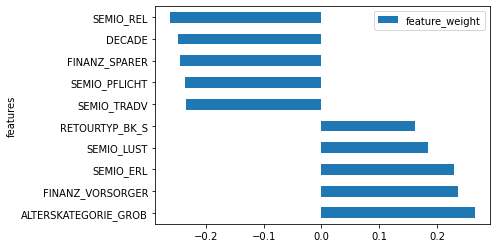

In [175]:
#High company data but low customer data
map_component_weights(2, pca_final)

LP_STATUS_GROB_3.0    0.2554
BUSINESS_BUILDINGS    0.2035
LP_STATUS_GROB_4.0    0.1936
KBA05_ANTG2           0.1771
ANZ_TITEL             0.1625
ARBEIT               -0.2032
REGIOTYP             -0.2087
LP_STATUS_GROB_5.0   -0.2126
KKK                  -0.2468
GEBAEUDETYP_RASTER   -0.2692
Name: 8, dtype: float64


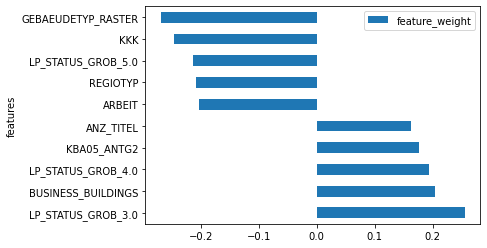

In [177]:
map_component_weights(9, pca_final)

### Discussion 3.3: Compare Customer Data to Demographics Data

***More in company:***

**Component 2**
Factors with the most positive correlation on component 2 include ALTERSKATEGORIE_GROB, FINANZ_VORSORGER, SEMIO_ERL, SEMIO_LUST, and RETOURTYP_BK_S.

Factors with the most negative correlation on component 2 include SEMIO_REL, DECADE, FINANZ_SPARER, SEMIO_PFLICHT, and SEMIO_TRADV.

From the factors above, we can infer that component 2 is highly correlated with older, less modern, more religious, more fiscally conservative and traditional. Less sensual and basically minimalist shoppers. 

**Component 9**
Factors with the most positive correlation on component 9 include LP_STATUS_GROB_3.0, BUSINESS_BUILDINGS, LP_STATUS_GROB_4.0, KBA05_ANTG2, and ANZ_TITEL.

Factors with the most negative correlation on component 9 nclude ARBEIT, REGIOTYP, LP_STATUS_GROB_5.0, KKK, and GEBAEUDETYP_RASTER

This cluster correlated mostly with the middle class and 3-5 family size. It has a negative correlation with top earners and also a negative correlation with low-income such as unemployment, low purchasing power.

***More in customer:***

**Component 3**
Factors with the most positive correlation on component 3 include SEMIO_VERT, SEMIO_SOZ, SEMIO_FAM, SEMIO_KULT, and FINANZ_MINIMALIST.

Factors with the most negative correlation on component 3 include SEMIO_RAT, SEMIO_KRIT, SEMIO_DOM, SEMIO_KAEM, and ANREDE_KZ_2.0.

From the factors above we can infer that component 3 is more correlated with being less dreamful, not as socially or culturally minded, being financially minimalist, having a higher affinity for being rational and critical, being more dominant and combative and being predominantly male over female.

**Component 10**
Factors with the most positive correlation on component 10 include VERS_TYP_2.0, LP_FAMILIE_GROB_5.0, SHOPPER_TYP_2.0, OST_WEST_KZ_W, and HEALTH_TYP.

Factors with the most negative correlation on component 10 include SEMIO_MAT, LP_FAMILIE_GROB_4.0, SHOPPER_TYP_1.0, LP_STATUS_GROB_4.0, and MIN_GEBAEUDEJAHR.

This cluster was all over the place. It had a correlation with multi person household, they are not super healthy. They tend to be family shoppers with family sizes over 8. They tend to be materialistic, from the West and not house owners.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.